In [ ]:
#
# Feature Reduction in h2o (autoencoders)
#

In [68]:
import h2o
import h2o.grid
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.20.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.20.04, mixed mode, sharing)
  Starting server from /home/gerd/Documents/Python/venvs/h2o/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp55udao2j
  JVM stdout: /tmp/tmp55udao2j/h2o_gerd_started_from_python.out
  JVM stderr: /tmp/tmp55udao2j/h2o_gerd_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Vienna
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,2 months and 3 days
H2O_cluster_name:,H2O_from_python_gerd_szenkd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.867 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [70]:
url = 'http://h2o-public-test-data.s3.amazonaws.com/smalldata/iris/iris_wheader.csv'
iris = h2o.import_file(url)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [71]:
train, test = iris.split_frame([0.8], seed=69)

In [6]:
X = test.columns
X.remove("class")

In [7]:
#
# dataset has 4 input nodes
#
model_autoencoder = H2OAutoEncoderEstimator( hidden=[4], activation='Tanh', epochs=300, model_id='autoencoder',
                                            # generally leave the following as default, unless for investigating
                                            train_samples_per_iteration=train.nrow, score_interval=0, score_duty_cycle=1.0)

#
# for autoencoders, use None for the target argument
#
%time model_autoencoder.train(X, None, train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 159 ms, sys: 13.1 ms, total: 172 ms
Wall time: 2.36 s


In [15]:
#
# rmse and mse represent reconstruction error for autoencoders i.e. how similar the 4 output nodes are to the 4 input nodes in this case 
#

model_autoencoder.scoring_history()

,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_mse
0,,2021-07-03 10:10:00,0.184 sec,0.00000 obs/sec,0.0,0,0.0,0.439850,0.193468
1,,2021-07-03 10:10:00,0.219 sec,3696 obs/sec,1.0,1,122.0,0.356224,0.126896
2,,2021-07-03 10:10:00,0.228 sec,6256 obs/sec,2.0,2,244.0,0.308014,0.094873
3,,2021-07-03 10:10:00,0.237 sec,8133 obs/sec,3.0,3,366.0,0.275565,0.075936
4,,2021-07-03 10:10:00,0.245 sec,9760 obs/sec,4.0,4,488.0,0.231687,0.053679
...,...,...,...,...,...,...,...,...,...
296,,2021-07-03 10:10:02,2.082 sec,23328 obs/sec,296.0,296,36112.0,0.008617,0.000074
297,,2021-07-03 10:10:02,2.088 sec,23331 obs/sec,297.0,297,36234.0,0.008029,0.000064
298,,2021-07-03 10:10:02,2.096 sec,23305 obs/sec,298.0,298,36356.0,0.008161,0.000067
299,,2021-07-03 10:10:02,2.102 sec,23308 obs/sec,299.0,299,36478.0,0.008074,0.000065


<AxesSubplot:>

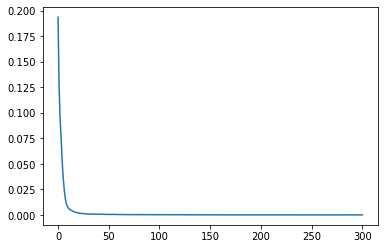

In [21]:
score_history = model_autoencoder.scoring_history()
score_history['training_mse'].plot()

<AxesSubplot:>

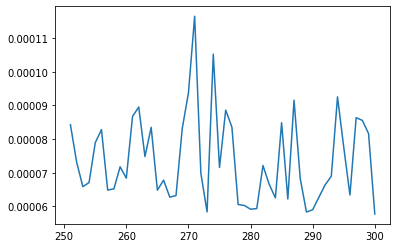

In [33]:
# only pick last n samples of scoring_history data
score_history['training_mse'].tail(50).plot()

In [48]:
# trying to reduce number of input features from 4 (originally) to only 2
model_autoencoder = H2OAutoEncoderEstimator( hidden=[2], activation='Tanh', epochs=300, model_id='autoencoder',
                                            # generally leave the following as default, unless for investigating
                                            train_samples_per_iteration=train.nrow, score_interval=0, score_duty_cycle=1.0, stopping_rounds=15)

%time model_autoencoder.train(X, None, train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 50.1 ms, sys: 10 ms, total: 60.1 ms
Wall time: 1.06 s


<AxesSubplot:>

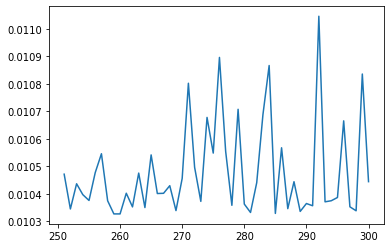

In [47]:
score_history = model_autoencoder.scoring_history()
score_history['training_mse'].tail(50).plot()

In [49]:
# multi layer autoencoding
model_autoencoder_multi = H2OAutoEncoderEstimator( hidden=[5, 3, 5], activation='Tanh', epochs=300, model_id='autoencoder_multi',
                                            # generally leave the following as default, unless for investigating
                                            train_samples_per_iteration=train.nrow, score_interval=0, score_duty_cycle=1.0, stopping_rounds=15)

%time model_autoencoder.train(X, None, train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 58.4 ms, sys: 12.5 ms, total: 70.8 ms
Wall time: 1.08 s


<AxesSubplot:>

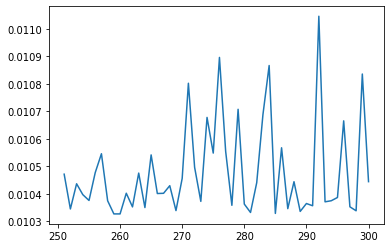

In [52]:
score_history_multi = model_autoencoder_multi
score_history['training_mse'].tail(50).plot()

In [80]:
# finding anomalies in data

# use all columns here
X = test.columns

# choose more hidden layers here, since were not trying to reduce dimensions
model_autoencoder_anomalies = H2OAutoEncoderEstimator( hidden=[15], activation='Tanh', epochs=300, model_id='anomaly',
                                            train_samples_per_iteration=train.nrow, score_interval=0, score_duty_cycle=1.0, stopping_rounds=15)

# use full dataset, not just training data
%time model_autoencoder.train(X, None, iris)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 85 ms, sys: 12.2 ms, total: 97.2 ms
Wall time: 1.3 s


In [81]:
model_autoencoder_anomalies = h2o.get_model('autoencoder')

In [82]:
# return single column h2o frame that contains reconstruction error (anomaly function), 
# bind in original data columns 
# and save as pd dataframe
anomalies = model_autoencoder_anomalies.anomaly(iris).cbind(iris).as_data_frame()

In [83]:
sorted_anomalies = anomalies.sort_values("Reconstruction.MSE", ascending=False)

In [84]:
# most anomalous columns
# these should be investigated in more details usually
sorted_anomalies.head()

,Reconstruction.MSE,sepal_len,sepal_wid,petal_len,petal_wid,class
106,0.039230,4.9,2.5,4.5,1.7,Iris-virginica
131,0.032232,7.9,3.8,6.4,2.0,Iris-virginica
117,0.030097,7.7,3.8,6.7,2.2,Iris-virginica
41,0.028320,4.5,2.3,1.3,0.3,Iris-setosa
15,0.027405,5.7,4.4,1.5,0.4,Iris-setosa


In [85]:
# least anomalous columns
sorted_anomalies.tail()

,Reconstruction.MSE,sepal_len,sepal_wid,petal_len,petal_wid,class
11,0.000436,4.8,3.4,1.6,0.2,Iris-setosa
40,0.000409,5.0,3.5,1.3,0.3,Iris-setosa
49,0.000284,5.0,3.3,1.4,0.2,Iris-setosa
39,0.000207,5.1,3.4,1.5,0.2,Iris-setosa
7,0.000074,5.0,3.4,1.5,0.2,Iris-setosa


In [67]:
h2o.cluster().shutdown()

H2O session _sid_88d9 closed.
